In [235]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import scale # To normalize features

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Dataset

In [2]:
df_stock = pd.read_csv('Stock_Market.csv')
df_stock.head()

,Unnamed: 0,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,3,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,4,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,5,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [3]:
df_stock.drop('Unnamed: 0', inplace = True, axis = 1)

### Correlation Between Features

In [4]:
corr = df_stock.corr()
corr

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


<IPython.core.display.Javascript object>


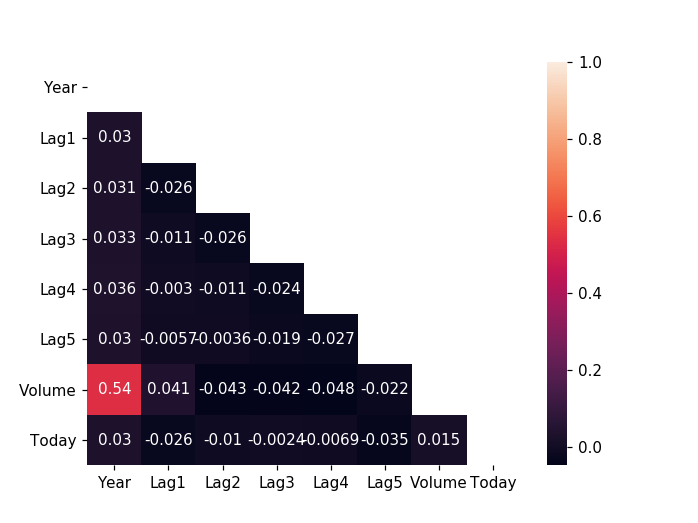

In [5]:
%matplotlib notebook
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, mask = mask, fmt = '.2g', annot=True)
plt.savefig('correlation.png', dpi = 100)

<IPython.core.display.Javascript object>


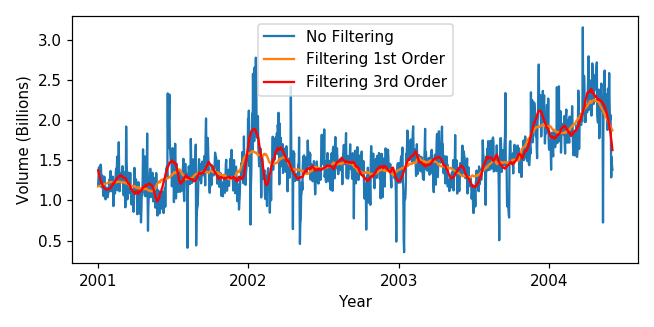

In [6]:
%matplotlib notebook
plt.figure(figsize=(6, 3))
plt.plot(df_stock.index, df_stock['Volume'], label = 'No Filtering')
plt.xticks(np.arange(0, df_stock.index[-1], 365), [2001, 2002, 2003, 2004])  # Set labels.
plt.xlabel('Year')
plt.ylabel('Volume (Billions)')

# To filter data
from scipy.signal import savgol_filter
filtered_data_1st = savgol_filter(np.array(df_stock['Volume']), 61, 1)
plt.plot(df_stock.index, filtered_data_1st, label = 'Filtering 1st Order')

filtered_data_3rd = savgol_filter(np.array(df_stock['Volume']), 61, 3)
plt.plot(df_stock.index, filtered_data_3rd, label = 'Filtering 3rd Order', color = 'r')

plt.legend()

plt.tight_layout()
plt.savefig('Volume_vs_Year.png', dpi = 100)

### Logistic Regression

Using Sklearn

In [7]:
x = df_stock.iloc[:, 1:7].values
y = df_stock['Direction'].values

model_LR = LogisticRegression()
model_LR.fit(x, y)
prediction_LR = model_LR.predict(x)
print('Model Prediction of Direction: ', prediction_LR[:5])
print('Actual dDirection:             ', y[:5])

print('Coeeficients:  ', model_LR.coef_)

Model Prediction of Direction:  ['Up' 'Down' 'Down' 'Up' 'Up']
Actual dDirection:              ['Up' 'Up' 'Down' 'Up' 'Up']
Coeeficients:   [[-0.07284345 -0.04223481  0.0110163   0.00928427  0.01026372  0.13211221]]


Using Statsmodels

In [8]:
x_sm = sm.add_constant(x)
y_sm = [1 if i == 'Up' else 0 for i in y]
logit = sm.Logit(y_sm,x_sm)
results = logit.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.691034
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1250
Model:                          Logit   Df Residuals:                     1243
Method:                           MLE   Df Model:                            6
Date:                Sun, 06 Sep 2020   Pseudo R-squ.:                0.002074
Time:                        22:19:21   Log-Likelihood:                -863.79
converged:                       True   LL-Null:                       -865.59
Covariance Type:            nonrobust   LLR p-value:                    0.7319
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1260      0.241     -0.523      0.601      -0.598       0.346
x1            -0.0731      0.

In [9]:
sm_prediction = results.predict(x_sm)
print(sm_prediction)
sm_prediction = ['Up' if i>0.5 else 'Down' for i in sm_prediction]
print(sm_prediction[:5])

[0.50708413 0.48146788 0.48113883 ... 0.5392683  0.52611829 0.51791656]
['Up', 'Down', 'Down', 'Up', 'Up']


In [10]:
# Compare coefficients in sklearn and statsmodels
print('Statsmodels Coefficients: \n', results.params)
print('Sklearm Logistic Regression Coefficients: \n', model_LR.coef_[0])

Statsmodels Coefficients: 
 [-0.12600026 -0.07307375 -0.04230134  0.01108511  0.00935894  0.01031307
  0.13544066]
Sklearm Logistic Regression Coefficients: 
 [-0.07284345 -0.04223481  0.0110163   0.00928427  0.01026372  0.13211221]


In [11]:
# Compare predicted direction using sklearn and statmodels
print('Statmodels prediction: ', sm_prediction[:10])
print('Sklearn predictions:   ', prediction_LR[:10])
print('Actual Direction:      ', y[:10])

Statmodels prediction:  ['Up', 'Down', 'Down', 'Up', 'Up', 'Up', 'Down', 'Up', 'Up', 'Down']
Sklearn predictions:    ['Up' 'Down' 'Down' 'Up' 'Up' 'Up' 'Down' 'Up' 'Up' 'Down']
Actual Direction:       ['Up' 'Up' 'Down' 'Up' 'Up' 'Up' 'Down' 'Up' 'Up' 'Up']


In [12]:
# confusion Matrix
conf_sm = confusion_matrix(y, sm_prediction) # confusion matrix of statmodels
conf_sk = confusion_matrix(y, prediction_LR) # confusion matricx of sklearn logistic regression

print('Statmodels confusion matrix: \n', conf_sm)
print('Sklearn confusion matrix: \n', conf_sk)

Statmodels confusion matrix: 
 [[145 457]
 [141 507]]
Sklearn confusion matrix: 
 [[144 458]
 [141 507]]


In [13]:
print('Accuracy score: {}'.format(accuracy_score(y, sm_prediction)))

Accuracy score: 0.5216


Split dataset into train and test

In [14]:
x_train = df_stock[df_stock['Year']<2005].iloc[:, 1:7].values
y_train = df_stock[df_stock['Year']<2005]['Direction'].values
x_test = df_stock[df_stock['Year'] == 2005].iloc[:, 1:7].values
y_test = df_stock[df_stock['Year'] == 2005]['Direction'].values

In [15]:
# train model on train data
x_train = sm.add_constant(x_train)
y_train_ud = [1 if i == 'Up' else 0 for i in y_train]
logit = sm.Logit(y_train_ud,x_train)
results_train = logit.fit()

sm_train_prediction = results_train.predict(x_train)
sm_train_prediction = ['Up' if i>0.5 else 'Down' for i in sm_train_prediction]

# Confusion matrix
conf_sm_train = confusion_matrix(y_train, sm_train_prediction)
print('Confusion matrix on train data: \n', conf_sm_train)

print('Accuracy score: {:.1f}%'.format(accuracy_score(y_train, sm_train_prediction)*100))

Optimization terminated successfully.
         Current function value: 0.691936
         Iterations 4
Confusion matrix on train data: 
 [[175 316]
 [156 351]]
Accuracy score: 52.7%


In [16]:
# Test the model on test data
x_test = sm.add_constant(x_test)
sm_test_prediction = results_train.predict(x_test)
sm_test_prediction = ['Up' if i>0.5 else 'Down' for i in sm_test_prediction]

# Confusion matrix
conf_sm_test = confusion_matrix(y_test, sm_test_prediction)
print('Confusion matrix on train data: \n', conf_sm_test)

print('Accuracy score: {:.1f}'.format(accuracy_score(y_test, sm_test_prediction)*100))

Confusion matrix on train data: 
 [[77 34]
 [97 44]]
Accuracy score: 48.0


<IPython.core.display.Javascript object>


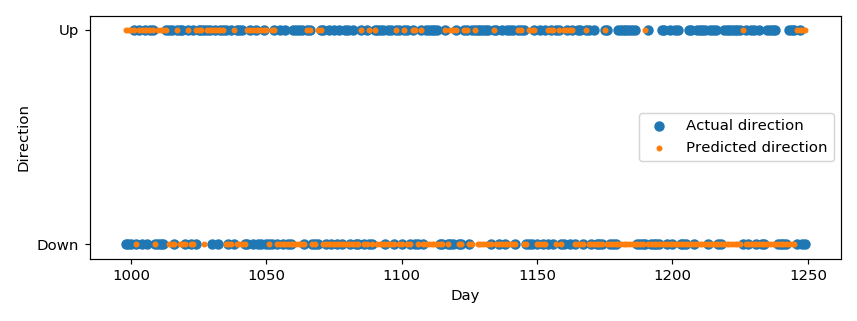

In [153]:
%matplotlib notebook
plt.figure(figsize=(8, 3))

plt.scatter(df_stock[df_stock['Year']==2005].index, df_stock[df_stock['Year']==2005]['Direction'], 
         label = 'Actual direction', marker = 'o')

plt.scatter(df_stock[df_stock['Year']==2005].index, sm_test_prediction, 
         label = 'Predicted direction', marker = '.')

plt.xlabel('Day')
plt.ylabel('Direction')
plt.legend()
plt.tight_layout()
plt.savefig('Actual_and_predicted_direction_2005.png', dpi = 100)

Let's make our model more effective by removing Lags with high value of p

In [74]:
x_train_L12 = df_stock[df_stock['Year']<2005][['Lag1', 'Lag2']].values
y_train_L12 = df_stock[df_stock['Year']<2005]['Direction'].values
x_test_L12 = df_stock[df_stock['Year'] == 2005][['Lag1', 'Lag2']].values
y_test_L12 = df_stock[df_stock['Year'] == 2005]['Direction'].values

array([-0.134,  0.008])

In [75]:
# train model on train data
x_train_L12 = sm.add_constant(x_train_L12)
y_train_ud_L12 = [1 if i == 'Up' else 0 for i in y_train_L12]
logit = sm.Logit(y_train_ud_L12,x_train_L12)
results_train_L12 = logit.fit()

sm_train_prediction_L12 = results_train_L12.predict(x_train_L12)
sm_train_prediction_L12 = ['Up' if i>0.5 else 'Down' for i in sm_train_prediction_L12]

# Confusion matrix
conf_sm_train_L12 = confusion_matrix(y_train_L12, sm_train_prediction_L12)
print('Confusion matrix on train data: \n', conf_sm_train_L12)

print('Accuracy score: {:.1f}%'.format(accuracy_score(y_train_L12, sm_train_prediction_L12)*100))

Optimization terminated successfully.
         Current function value: 0.692085
         Iterations 3
Confusion matrix on train data: 
 [[168 323]
 [160 347]]
Accuracy score: 51.6%


In [76]:
# Test the model on test data
x_test_L12 = sm.add_constant(x_test_L12)
sm_test_prediction_L12 = results_train_L12.predict(x_test_L12)
sm_test_prediction_ud_L12 = ['Up' if i>0.5 else 'Down' for i in sm_test_prediction_L12]

# Confusion matrix
conf_sm_test_L12 = confusion_matrix(y_test_L12, sm_test_prediction_ud_L12)
print('Confusion matrix on train data: \n', conf_sm_test_L12)

print('Accuracy score: {:.1f}'.format(accuracy_score(y_test_L12, sm_test_prediction_ud_L12)*100))

Confusion matrix on train data: 
 [[ 35  76]
 [ 35 106]]
Accuracy score: 56.0


In [77]:
y_test_ud_L12 = [1 if i == 'Up' else 0 for i in y_test_L12]
precision = precision_score(y_test_L12, sm_test_prediction_ud_L12, average=None)
print('Precision on Down direction: {:.1f}%, precision on Up direction: {:.1f}%'.format(*precision*100))

Precision on Down direction: 50.0%, precision on Up direction: 58.2%


In [100]:
# we want to predict Direction on a
#day when Lag1 and Lag2 equal 1.2 and 1.1, respectively, and on a day when
#they equal 1.5 and −0.8

x_point = np.array([[1, 1.2, 1.1], [1, 1.5, -0.8]])
sm_test_prediction_point = results_train_L12.predict(x_point)
print(sm_test_prediction_point.round(4))
# For both points the model predict Down direction

[0.4791 0.4961]


### Linear Discriminant Analysis

In [103]:
x_train_L12 = df_stock[df_stock['Year']<2005][['Lag1', 'Lag2']].values
y_train_L12 = df_stock[df_stock['Year']<2005]['Direction'].values
x_test_L12 = df_stock[df_stock['Year'] == 2005][['Lag1', 'Lag2']].values
y_test_L12 = df_stock[df_stock['Year'] == 2005]['Direction'].values

y_train_ud_L12 = [1 if i == 'Up' else 0 for i in y_train_L12]

In [117]:
# Create LDA model
model_LDA = LinearDiscriminantAnalysis(solver='lsqr',store_covariance=True)

# Fit the model using data before 2005. Data contains only Lag1 and Lag2 
results_LDA = model_LDA.fit(x_train_L12, y_train_L12)

#Group means:
results_LDA.means_.round(3)

array([[ 0.043,  0.034],
       [-0.04 , -0.031]])

In [114]:
# Prior probabilities of groups:
results_LDA.priors_.round(3)

array([0.492, 0.508])

In [116]:
# Coefficients of linear discriminants:
results_LDA.coef_.round(3)

array([[-0.056, -0.044]])

<IPython.core.display.Javascript object>


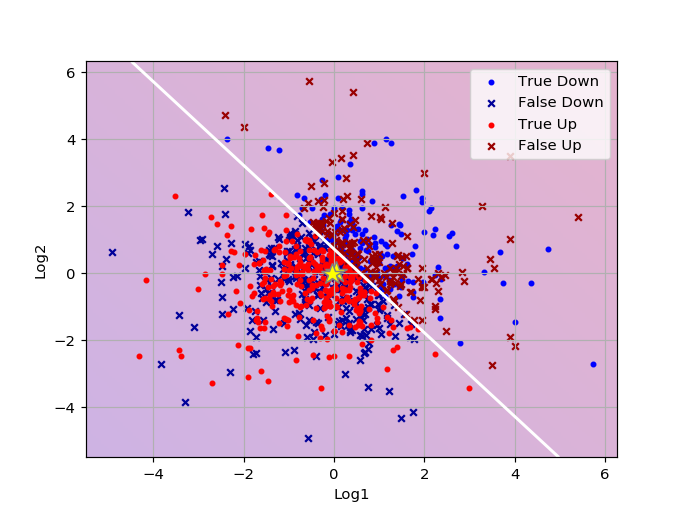

In [220]:
# Plot of LDA
# Taken and modified from:
# https://scikit-learn.org/stable/auto_examples/classification/
# plot_lda_qda.html#sphx-glr-auto-examples-classification-plot-lda-qda-py

%matplotlib notebook
from matplotlib import colors
from scipy import linalg
import matplotlib as mpl
# Colormap
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)

def plot_data(model, X, y, y_pred, model_type):
  #  splot = plt.subplot(1, 1, fig_index)
  #  if fig_index == 1:
  #      plt.title('Linear Discriminant Analysis')
  #  elif fig_index == 2:
  #      plt.title('Quadratic Discriminant Analysis')
    plt.figure()
    tp = (y == y_pred)  # True Positive
    tp0, tp1 = tp[y == 'Down'], tp[y == 'Up']
    X0, X1 = X[y == 'Down'], X[y == 'Up']
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    # class 0: dots
    plt.scatter(X0_tp[:, 0], X0_tp[:, 1], marker='.', color='blue', label = 'True Down')
    plt.scatter(X0_fp[:, 0], X0_fp[:, 1], marker='x',
                s=20, color='#000099', label = 'False Down')  # dark red
    
    plt.xlabel('Log1')
    plt.ylabel('Log2')

    # class 1: dots
    plt.scatter(X1_tp[:, 0], X1_tp[:, 1], marker='.', color='red', label = 'True Up')
    plt.scatter(X1_fp[:, 0], X1_fp[:, 1], marker='x',
                s=20, color= '#990000', label = 'False Up')  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 200
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes',
                   norm=colors.Normalize(0., 1.), zorder=0)
    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='white')
    
    if model_type[:3] != 'knn':
        # means
        plt.plot(model.means_[0][0], model.means_[0][1],
                 '*', color='yellow', markersize=15, markeredgecolor='grey')
        plt.plot(model.means_[1][0], model.means_[1][1],
                 '*', color='yellow', markersize=15, markeredgecolor='grey')

    plt.grid(which = 'both')
    plt.legend()
    plt.savefig( model_type +  '.png', dpi = 100)
    
train_prediction = results_LDA.predict(x_train_L12)
plot_data(model_LDA, x_train_L12, y_train_L12, train_prediction, 'LDA_train')

In [154]:
# Prediction on test dataset
prediction_LDA_test = results_LDA.predict(x_test_L12)

# Confusion matrix
cm_test_LDA = confusion_matrix(y_test_L12, prediction_LDA_test)

cm_test_LDA

array([[ 35,  76],
       [ 35, 106]], dtype=int64)

In [157]:
# Accuracy on test dataset
print('Accuracy score on test dataset: {:.1f}'.format(accuracy_score(y_test_L12, prediction_LDA_test)*100))

Accuracy score on test dataset: 56.0


### Quadratic Discriminant Analysis

In [159]:
x_train_L12 = df_stock[df_stock['Year']<2005][['Lag1', 'Lag2']].values
y_train_L12 = df_stock[df_stock['Year']<2005]['Direction'].values
x_test_L12 = df_stock[df_stock['Year'] == 2005][['Lag1', 'Lag2']].values
y_test_L12 = df_stock[df_stock['Year'] == 2005]['Direction'].values

y_train_ud_L12 = [1 if i == 'Up' else 0 for i in y_train_L12]

In [161]:
# Create LDA model
model_QDA = QuadraticDiscriminantAnalysis()

# Fit the model using data before 2005. Data contains only Lag1 and Lag2 
results_QDA = model_QDA.fit(x_train_L12, y_train_L12)

#Group means:
results_QDA.means_.round(3)

array([[ 0.043,  0.034],
       [-0.04 , -0.031]])

In [162]:
# Prior probabilities of groups:
results_QDA.priors_.round(3)

array([0.492, 0.508])

In [166]:
# Prediction on test dataset
prediction_QDA_test = results_QDA.predict(x_test_L12)

# Confusion matrix
cm_test_QDA = confusion_matrix(y_test_L12, prediction_QDA_test)

cm_test_QDA

array([[ 30,  81],
       [ 20, 121]], dtype=int64)

In [167]:
# Accuracy on test dataset
print('Accuracy score on test dataset: {:.1f}'.format(accuracy_score(y_test_L12, prediction_QDA_test)*100))

Accuracy score on test dataset: 59.9


<IPython.core.display.Javascript object>


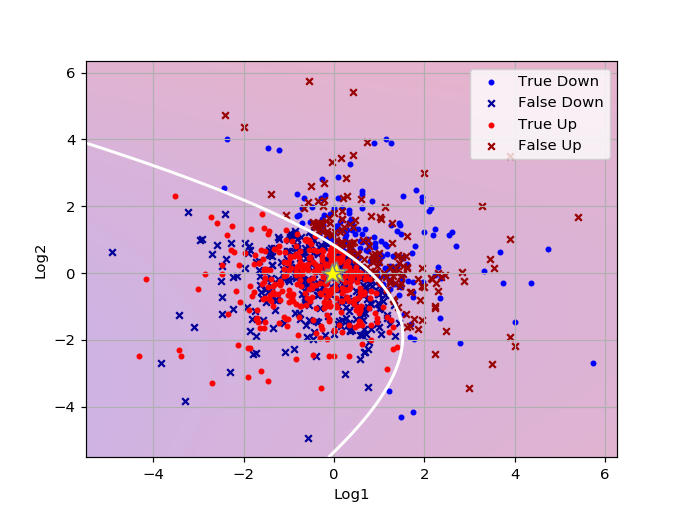

In [218]:
%matplotlib notebook
train_prediction_QDA = results_QDA.predict(x_train_L12)
plot_data(model_QDA, x_train_L12, y_train_L12, train_prediction_QDA, 'QDA_train')

<IPython.core.display.Javascript object>


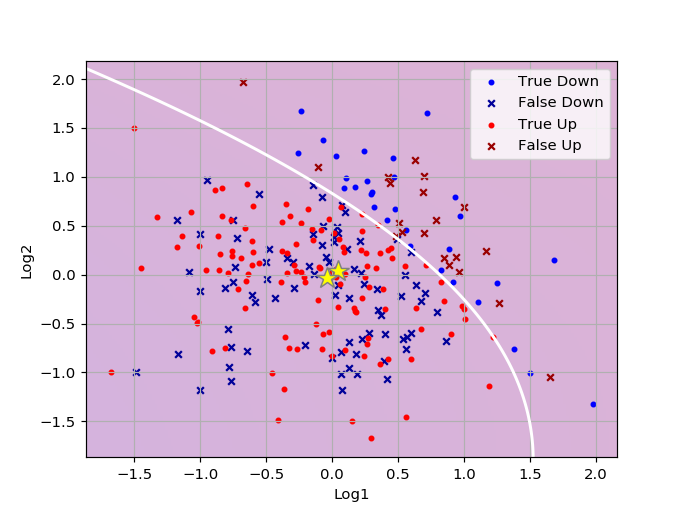

In [219]:
%matplotlib notebook
test_prediction_QDA = results_QDA.predict(x_test_L12)
plot_data(model_QDA, x_test_L12, y_test_L12, test_prediction_QDA, 'QDA_test')

### K-Nearest Neighbors

In [186]:
x_train_L12 = df_stock[df_stock['Year']<2005][['Lag1', 'Lag2']].values
y_train_L12 = df_stock[df_stock['Year']<2005]['Direction'].values
x_test_L12 = df_stock[df_stock['Year'] == 2005][['Lag1', 'Lag2']].values
y_test_L12 = df_stock[df_stock['Year'] == 2005]['Direction'].values

y_train_ud_L12 = [1 if i == 'Up' else 0 for i in y_train_L12]

#### n_neighbor = 1

In [195]:
# Lets start with only 1 neighbor
model_knn = KNeighborsClassifier(n_neighbors=1)
model_knn.fit(x_train_L12, y_train_L12)
prediction_knn_test = model_knn.predict(x_test_L12)

In [196]:
# Confusion matrix
cm_test_knn = confusion_matrix(y_test_L12, prediction_knn_test)

cm_test_knn

array([[43, 68],
       [58, 83]], dtype=int64)

In [197]:
# Accuracy on test dataset
print('Accuracy score on test dataset: {:.1f}'.format(accuracy_score(y_test_L12, prediction_knn_test)*100))

Accuracy score on test dataset: 50.0


#### n_neighbor = 3

In [201]:
# Lets try with 3 neighbors
model_knn = KNeighborsClassifier(n_neighbors=3)
model_knn.fit(x_train_L12, y_train_L12)
prediction_knn_test = model_knn.predict(x_test_L12)

In [202]:
# Confusion matrix
cm_test_knn = confusion_matrix(y_test_L12, prediction_knn_test)

cm_test_knn

array([[48, 63],
       [55, 86]], dtype=int64)

In [203]:
# Accuracy on test dataset
print('Accuracy score on test dataset: {:.1f}'.format(accuracy_score(y_test_L12, prediction_knn_test)*100))

Accuracy score on test dataset: 53.2


<IPython.core.display.Javascript object>


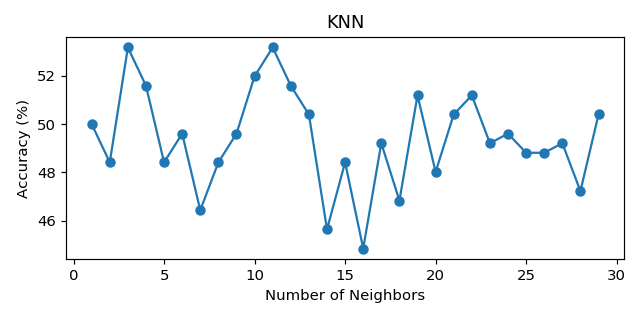

In [322]:
accuracy_list = []
for n in range(1, 30):
    model_knn = KNeighborsClassifier(n_neighbors=n)
    model_knn.fit(x_train_L12, y_train_L12)
    prediction_knn_test = model_knn.predict(x_test_L12)
    accuracy_list.append(accuracy_score(y_test_L12, prediction_knn_test)*100)

%matplotlib notebook
plt.figure(figsize=(6, 3))
plt.plot(range(1, 30), accuracy_list, marker = 'o', label = 'Test')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy (%)')
plt.title('KNN')
plt.tight_layout()
plt.savefig('KNN_Accuracy.png')

<IPython.core.display.Javascript object>


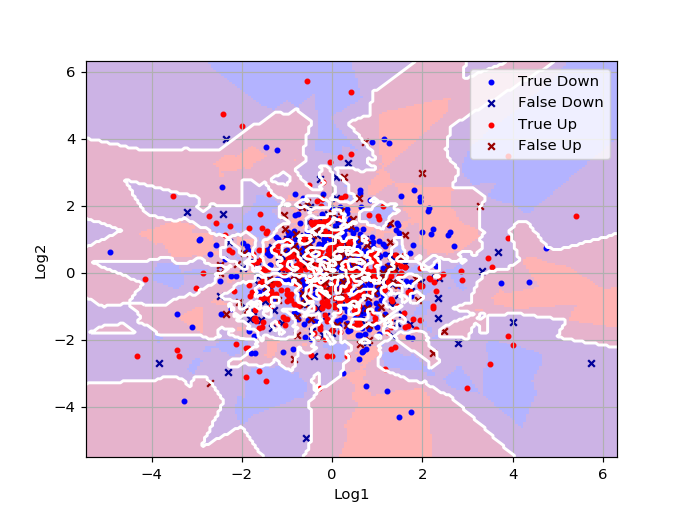

In [226]:
%matplotlib notebook

model_knn = KNeighborsClassifier(n_neighbors=3)
model_knn.fit(x_train_L12, y_train_L12)
prediction_knn_test = model_knn.predict(x_test_L12)
prediction_knn_train = model_knn.predict(x_train_L12)

plot_data(model_knn, x_train_L12, y_train_L12, prediction_knn_train, 'knn_train')

<IPython.core.display.Javascript object>


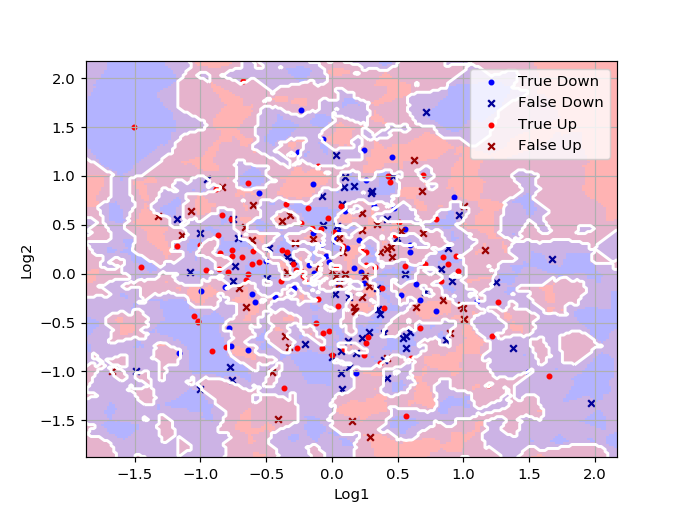

In [227]:
plot_data(model_knn, x_test_L12, y_test_L12, prediction_knn_test, 'knn_test')

### An Application to Caravan Insurance Data

In [231]:
df_caravan = pd.read_csv('Caravan.csv')
df_caravan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 87 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5822 non-null   int64 
 1   MOSTYPE     5822 non-null   int64 
 2   MAANTHUI    5822 non-null   int64 
 3   MGEMOMV     5822 non-null   int64 
 4   MGEMLEEF    5822 non-null   int64 
 5   MOSHOOFD    5822 non-null   int64 
 6   MGODRK      5822 non-null   int64 
 7   MGODPR      5822 non-null   int64 
 8   MGODOV      5822 non-null   int64 
 9   MGODGE      5822 non-null   int64 
 10  MRELGE      5822 non-null   int64 
 11  MRELSA      5822 non-null   int64 
 12  MRELOV      5822 non-null   int64 
 13  MFALLEEN    5822 non-null   int64 
 14  MFGEKIND    5822 non-null   int64 
 15  MFWEKIND    5822 non-null   int64 
 16  MOPLHOOG    5822 non-null   int64 
 17  MOPLMIDD    5822 non-null   int64 
 18  MOPLLAAG    5822 non-null   int64 
 19  MBERHOOG    5822 non-null   int64 
 20  MBERZELF

In [240]:
# Null values
df_caravan.isnull().sum()

Unnamed: 0    0
MOSTYPE       0
MAANTHUI      0
MGEMOMV       0
MGEMLEEF      0
             ..
APLEZIER      0
AFIETS        0
AINBOED       0
ABYSTAND      0
Purchase      0
Length: 87, dtype: int64

In [247]:
# Statistics on purchased inssurance
y_caravan = df_caravan['Purchase']
y_caravan.describe()

count     5822
unique       2
top         No
freq      5474
Name: Purchase, dtype: object

In [266]:
# Normalize features

# Before normalization:
x_caravan = df_caravan.iloc[:, 1:86].values
print('Mean and std of the 1st column before normalization')
print(x_caravan[:, 0].mean())
print(x_caravan[:, 0].std())

# After normalization
x_caravan = scale(df_caravan.iloc[:, 1:86].values)
print('\n Mean and std of the 1st column after normalization')
print(x_caravan[:, 0].mean())
print(x_caravan[:, 0].std())

Mean and std of the 1st column before normalization
24.25334936447956
12.84560236493673

 Mean and std of the 1st column after normalization
-7.749822006315075e-17
1.0


In [304]:
# change target column into 1 and 0 instead of Yes and No. 
y_caravan = [1 if i=='Yes' else 0 for i in df_caravan['Purchase'].values]

In [305]:
# split data into train and test, 1000 rows for test and the rest for training
test_size = 1000/df_caravan.shape[0]
print('Test size: {:.3f}'.format(test_size))

X_train, X_test, y_train, y_test = train_test_split(x_caravan, y_caravan, test_size=test_size, random_state=42)

Test size: 0.172


#### K = 1

In [306]:
# Creat a knn model with k = 1
model_knn = KNeighborsClassifier(n_neighbors=1)
model_knn.fit(X_train, y_train)
prediction_knn_test = model_knn.predict(X_test)
prediction_knn_train = model_knn.predict(X_train)

In [307]:
# Error rate
print('Error rate on test dataset:     {:.1f}%'.format(np.mean(prediction_knn_test != y_test)*100))
print('Error rate on training dataset: {:.2f}% \n'.format(np.mean(prediction_knn_train != y_train)*100))


# Precision score
print('Precision score on test dataset     {}%'.format(precision_score(y_test, prediction_knn_test)*100))
print('Precision score on trainign dataset {}%'.format(precision_score(y_train, prediction_knn_train)*100))

Error rate on test dataset:     12.5%
Error rate on training dataset: 0.73% 

Precision score on test dataset     12.0%
Precision score on trainign dataset 94.87179487179486%


In [308]:
# Confusion matrix on test dataset
cm_test_knn = confusion_matrix(y_test, prediction_knn_test)
cm_test_knn

array([[866,  66],
       [ 59,   9]], dtype=int64)

In [295]:
# Confusion matrix on training dataset
cm_train_knn = confusion_matrix(y_train, prediction_knn_train)
cm_train_knn

array([[4528,   14],
       [  21,  259]], dtype=int64)

#### K = 3

In [300]:
# Creat a knn model with k = 3
X_train, X_test, y_train, y_test = train_test_split(x_caravan, y_caravan, test_size=test_size, random_state=42)

model_knn = KNeighborsClassifier(n_neighbors=3)
model_knn.fit(X_train, y_train)
prediction_knn_test = model_knn.predict(X_test)
prediction_knn_train = model_knn.predict(X_train)

In [301]:
# Error rate
print('Error rate on test dataset:     {:.1f}%'.format(np.mean(prediction_knn_test != y_test)*100))
print('Error rate on training dataset: {:.2f}% \n'.format(np.mean(prediction_knn_train != y_train)*100))


# Precision score
print('Precision score on test dataset     {}%'.format(precision_score(y_test, prediction_knn_test)*100))
print('Precision score on trainign dataset {}%'.format(precision_score(y_train, prediction_knn_train)*100))

Error rate on test dataset:     8.5%
Error rate on training dataset: 5.27% 

Precision score on test dataset     16.0%
Precision score on trainign dataset 65.11627906976744%


In [302]:
# Confusion matrix on test dataset
cm_test_knn = confusion_matrix(y_test, prediction_knn_test)
cm_test_knn

array([[911,  21],
       [ 64,   4]], dtype=int64)

In [303]:
# Confusion matrix on training dataset
cm_train_knn = confusion_matrix(y_train, prediction_knn_train)
cm_train_knn

array([[4512,   30],
       [ 224,   56]], dtype=int64)

#### K = 5

In [309]:
# Creat a knn model with k = 5
X_train, X_test, y_train, y_test = train_test_split(x_caravan, y_caravan, test_size=test_size, random_state=42)

model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train, y_train)
prediction_knn_test = model_knn.predict(X_test)
prediction_knn_train = model_knn.predict(X_train)

In [315]:
# Error rate
print('Error rate on test dataset:     {:.1f}%'.format(np.mean(prediction_knn_test != y_test)*100))
print('Error rate on training dataset: {:.1f}% \n'.format(np.mean(prediction_knn_train != y_train)*100))


# Precision score
print('Precision score on test dataset     {:.1f}%'.format(precision_score(y_test, prediction_knn_test)*100))
print('Precision score on trainign dataset {:.1f}%'.format(precision_score(y_train, prediction_knn_train)*100))

Error rate on test dataset:     7.4%
Error rate on training dataset: 5.6% 

Precision score on test dataset     20.0%
Precision score on trainign dataset 62.2%


In [311]:
# Confusion matrix on test dataset
cm_test_knn = confusion_matrix(y_test, prediction_knn_test)
cm_test_knn

array([[924,   8],
       [ 66,   2]], dtype=int64)

In [312]:
# Confusion matrix on training dataset
cm_train_knn = confusion_matrix(y_train, prediction_knn_train)
cm_train_knn

array([[4528,   14],
       [ 257,   23]], dtype=int64)

In [317]:
precision_test, precision_train = [], []
for k in range(1, 20):
    print(k)
    model_knn = KNeighborsClassifier(n_neighbors=k)
    model_knn.fit(X_train, y_train)
    prediction_knn_test = model_knn.predict(X_test)
    prediction_knn_train = model_knn.predict(X_train)
    precision_test.append(precision_score(y_test, prediction_knn_test)*100)
    precision_train.append(precision_score(y_train, prediction_knn_train)*100)

1
2
3
4
5
6
7
8
9
10
11
12


C:\Users\u0125384\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


13
14


C:\Users\u0125384\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15


C:\Users\u0125384\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


16


C:\Users\u0125384\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


17


C:\Users\u0125384\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


18


C:\Users\u0125384\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


19


C:\Users\u0125384\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<IPython.core.display.Javascript object>


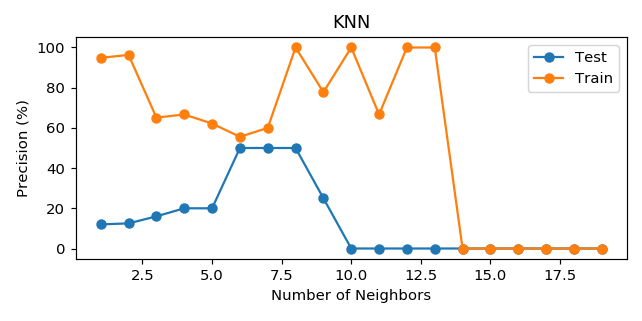

In [323]:
%matplotlib notebook
plt.figure(figsize=(6, 3))
plt.plot(range(1, 20), precision_test, marker = 'o', label = 'Test')
plt.plot(range(1, 20), precision_train, marker = 'o', label = 'Train')
plt.xlabel('Number of Neighbors')
plt.ylabel('Precision (%)')
plt.title('KNN')
plt.legend()
plt.tight_layout()
plt.savefig('KNN_Precision_caravan.png')